In [1]:
from mtcnn.src import detect_faces
from PIL import Image
import cv2
import numpy as np
import  matplotlib.pyplot as plt
import random
from face_parser import FaceParser, preproccess
import torchvision.transforms.functional as TF
import torch.nn.functional as F

random.seed(100)

threshold = 10

In [2]:
def imshow(img):
    """
    jupyter imshow
    """
    plt.figure(dpi=300)
    plt.axis('off')
    img = img[:,:,::-1] 	# transform image to rgb
    plt.imshow(img)
    plt.show()

## Face Segmentation

In [3]:
# Read original image
original_image = Image.open('images/Presidents.jpg')
bounding_boxes, landmarks = detect_faces(original_image, thresholds=[0.6, 0.7, 0.85])
bounding_boxes = bounding_boxes.astype(int)

In [4]:
# visualize the detected results
def visualize_box(original_image, bounding_boxes):
    image = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
    # Loop each face
    for i in range(len(bounding_boxes)):
        box = bounding_boxes[i]
        # Different color denote different face
        color = [random.randint(0,255),random.randint(0,255),random.randint(0,255)]
        # Label the face box
        cv2.rectangle(image, (box[0],box[1]),(box[2], box[3]), color, 2)
    imshow(image)
    return image

In [5]:
def enlarge_face_region(bounding_boxes, image_shape, scale = 1.5):
    """
    bounding_boxes: [box1, box2, ... , box n]
    """
    new_bounding_boxes = []
    for bounding_box in bounding_boxes:
        center_row = (bounding_box[0] + bounding_box[2]) / 2
        center_col = (bounding_box[1] + bounding_box[3]) / 2
        height = bounding_box[2] - bounding_box[0]
        width =  bounding_box[3] - bounding_box[1]

        length = max(height, width)

        # new box
        x1 = int(center_row - scale * length/2)
        if x1 < 0:
            x1 = 0
        y1 = int(center_col - scale * length/2)
        if y1 < 0:
            y1 = 0
        x2 = int(center_row + scale * length/2)
        if x2 > image_shape[1] - 1:
            x2 = image_shape[1] - 1
        y2 = int(center_col + scale * length/2)
        if y2 > image_shape[0] - 1:
            y2 = image_shape[0] - 1

        new_bounding_boxes.append([x1, y1, x2, y2])
    return np.array(new_bounding_boxes)

In [6]:
# In order to segment the face, it is first necessary to enlarge the face area
image = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
new_bounding_boxes = enlarge_face_region(bounding_boxes, image.shape, scale = 1.5)

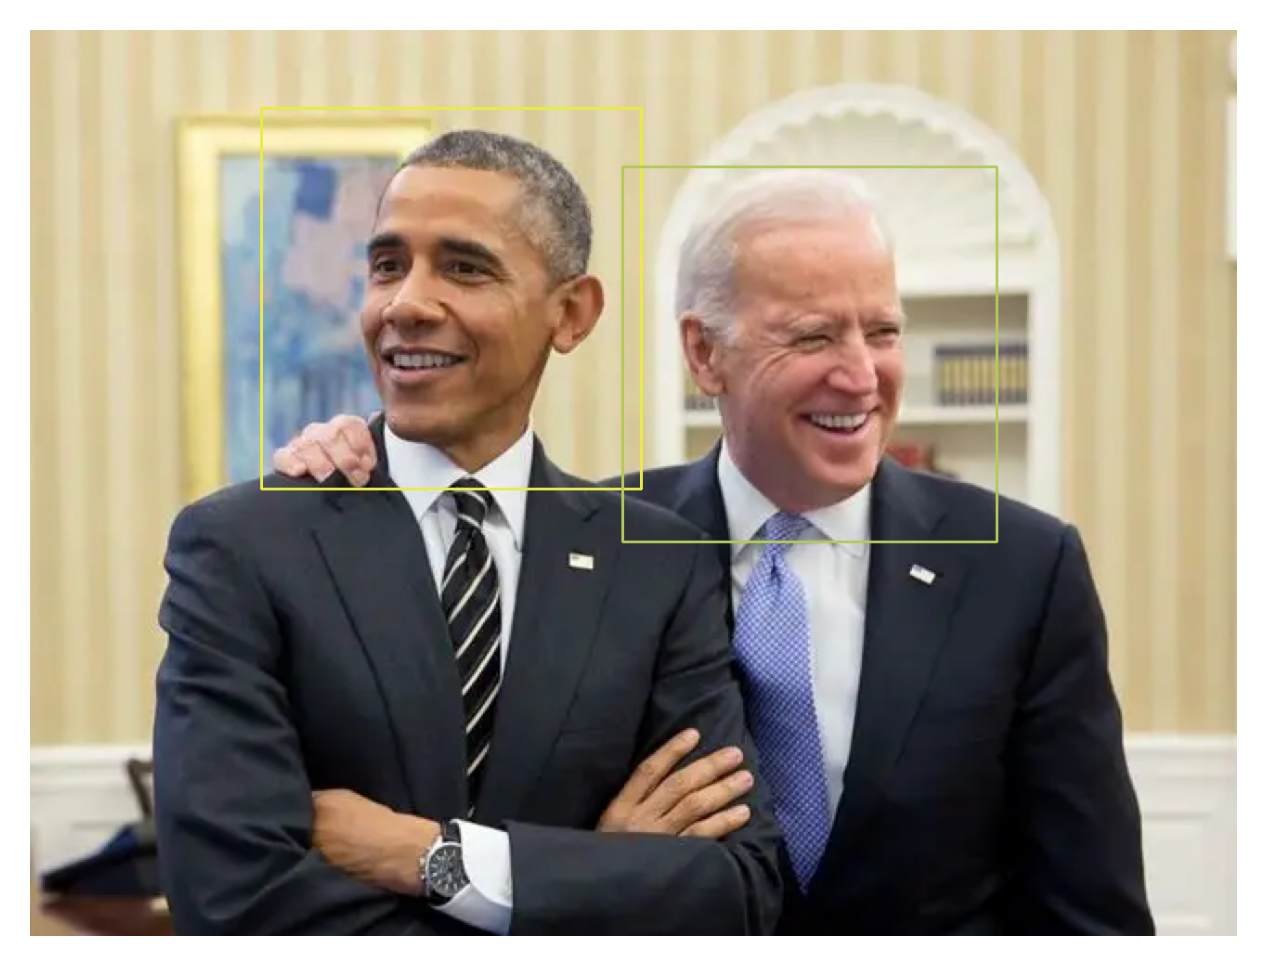

True

In [7]:
det_image = visualize_box(original_image, new_bounding_boxes)
cv2.imwrite("images/det_image.jpg", det_image)

In [8]:
model = FaceParser()

In [9]:
seg_result = np.ones((image.shape[0], image.shape[1]))*255

for bounding_box in new_bounding_boxes:
    face_image = image[bounding_box[1]:bounding_box[3], bounding_box[0]:bounding_box[2]]
    face_image_proccess = preproccess(face_image)
    # preproccessing
    parsed_face = model(face_image_proccess)
    parsed_face = F.interpolate(parsed_face, (bounding_box[3]- bounding_box[1], bounding_box[2]- bounding_box[0]), mode='bilinear')
    
    seg_face = ((parsed_face[0][1:8].numpy().mean(0)*255).astype(np.uint8) < threshold) * 255
    # seg_face = cv2.resize(seg_face, (bounding_box[3]- bounding_box[1], bounding_box[2]- bounding_box[0]))

    seg_result[bounding_box[1]:bounding_box[3], bounding_box[0]:bounding_box[2]] = seg_face

/home/zhangjunjie/.local/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [10]:
cv2.imwrite("images/seg_result.jpg", seg_result)

True

In [11]:
mask = np.ones((image.shape[0], image.shape[1], 3))
for channel in range(3):
    mask[:,:,channel] = mask[:,:,channel] * random.randint(0,255)

mask = mask * (1 - seg_result/255)[:,:,np.newaxis]
mask = mask.astype(np.uint8)

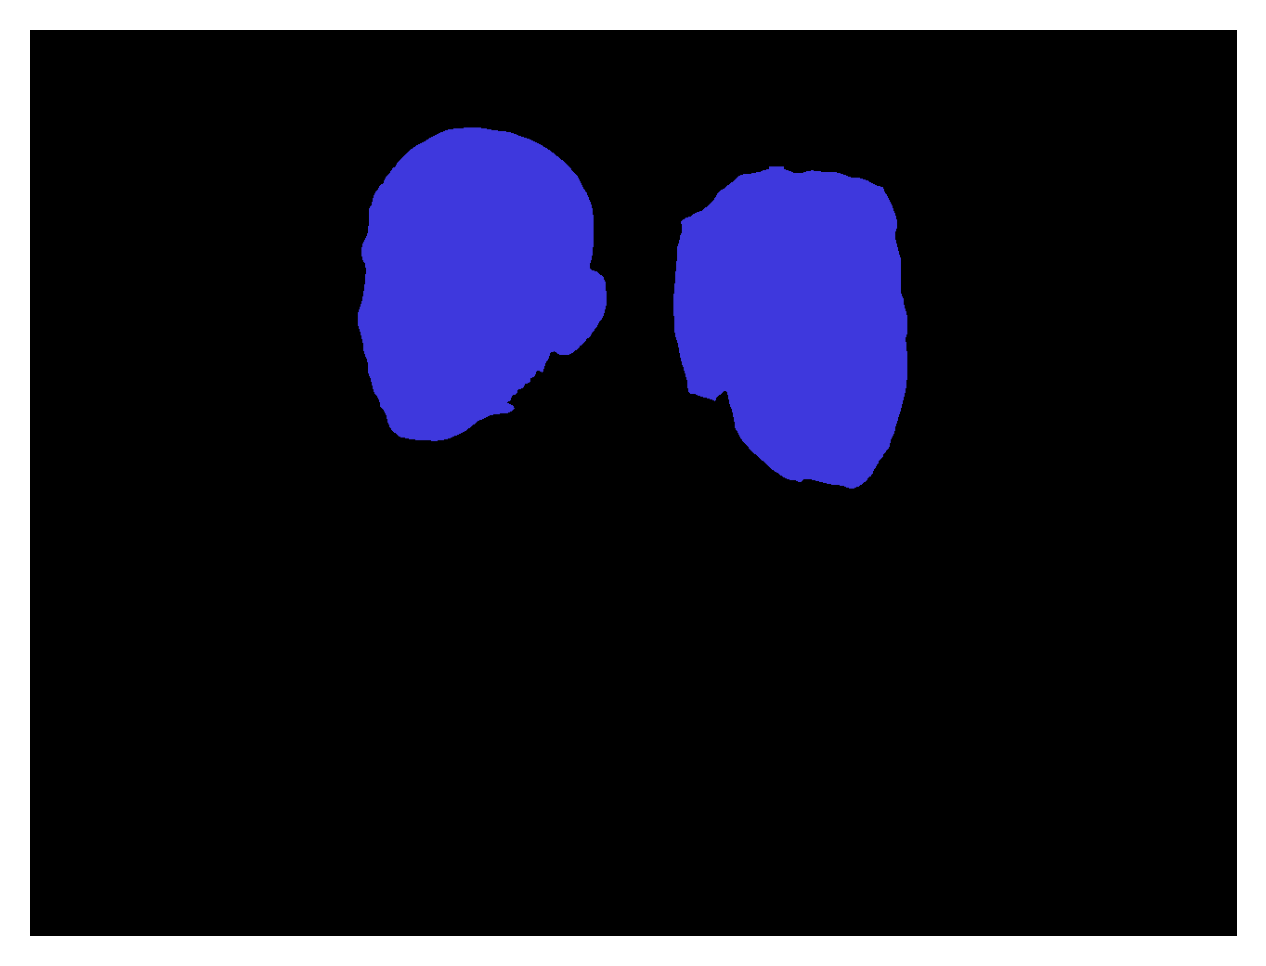

True

In [12]:
imshow(mask)
cv2.imwrite("images/mask.jpg", mask)

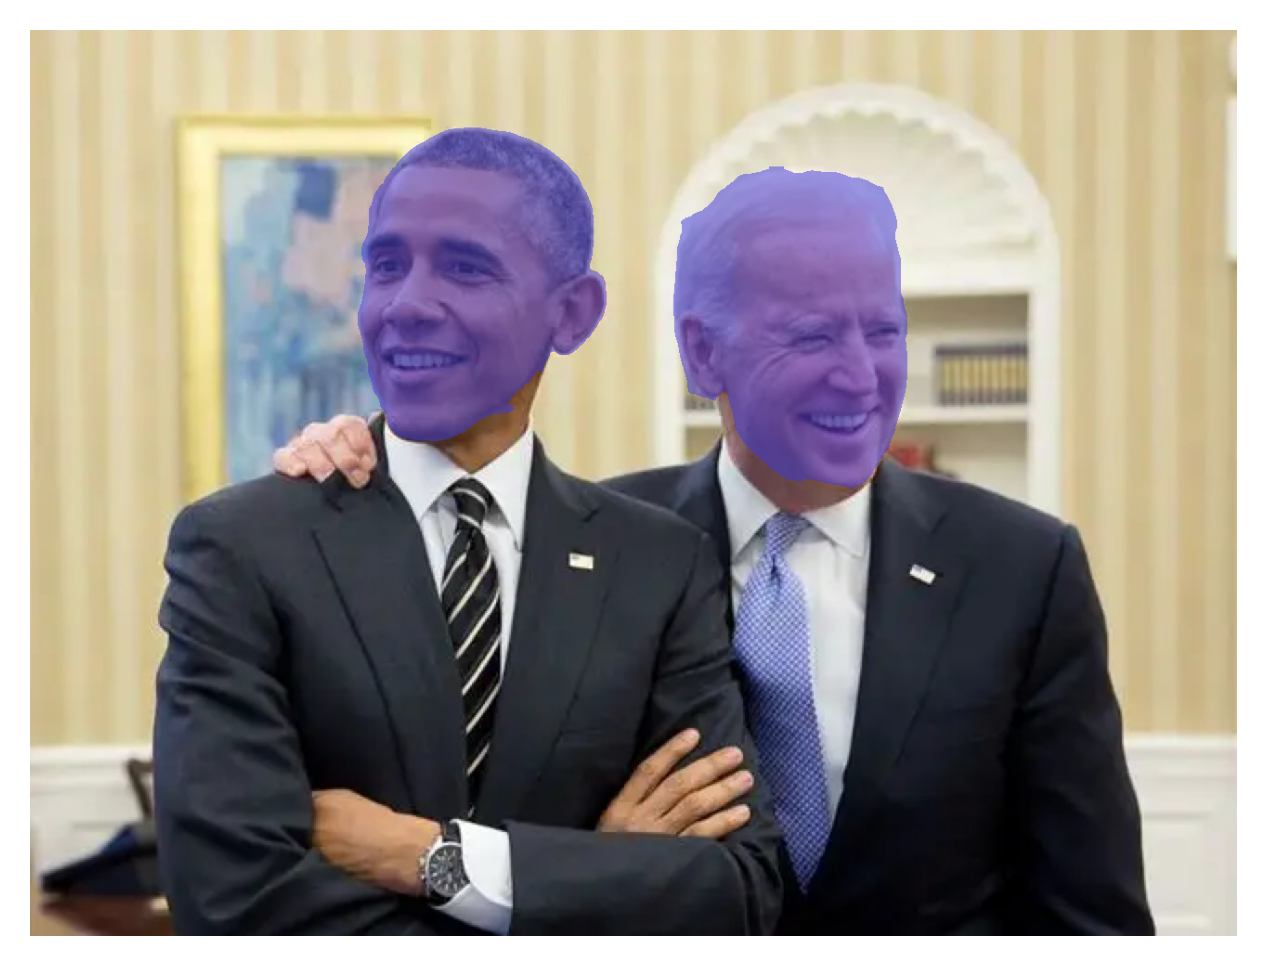

True

In [13]:
seg_ = seg_result/255
mask_image = image * seg_[:,:,np.newaxis] + 0.5 * image * (1 - seg_)[:,:,np.newaxis] + 0.5 * mask

imshow(mask_image.astype(np.uint8))
cv2.imwrite("images/mask_image.jpg", mask_image)